# Importação das bibliotecas necessárias

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils import shuffle
from tqdm.notebook import tqdm_notebook
import mlflow
from mlflow import log_metric, log_param, log_artifact
from mlflow.pytorch import log_model
import nibabel as nib
from sklearn.utils import shuffle
from tensorflow.keras.backend import one_hot

# Criação das rotinas de leitura de dados

In [ ]:
def generate_train_files():
    from sklearn.utils import shuffle
    TRAIN_DIR = "/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train/MICCAI_BraTS2020_TrainingData/"
    files = os.listdir(TRAIN_DIR)
    name_list = []
    for file in files:
        if (not (file.endswith(".csv"))):
            dir_temp = TRAIN_DIR + file
            files_inside = os.listdir(dir_temp)
            for i in files_inside:
                if i.split("_")[-1] in ["flair.nii.gz"]:
                    for j in range(155):
                        dir_final = dir_temp + "/" + i + "=" + str(j)
                        name_list.append(dir_final)                    
    return name_list

In [ ]:
files = generate_train_files()

In [ ]:
class DataSaver(Dataset):
    def __init__(self, files):
        self.data = files
        self.x_filenames = []
        self.volumes = []
        self.y_filenames = []
        self.slice = []
        
    def __len__(self):
        return len(self.data)

    def save(self):
        for e, dir in enumerate(tqdm_notebook(self.data)):
            dir, slice = dir.split("=")
            slice = int(slice)
            file = dir.split("/")[-2].split("_")[-1]
            dir_seg  = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}_seg.nii.gz' .format(file, file)
            x = nib.load(dir).get_fdata()[:, :, slice]
            x = (x - x.mean())/(x.std() + 1e-6)
            y = nib.load(dir_seg).get_fdata()[:, :, slice]
            y[y == 4] = 3
            y = one_hot(y, 4).numpy().transpose(2, 0, 1)
            save_dir = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train_NPY/X/{}' .format(e)
            np.save(save_dir, x)
            save_dir = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train_NPY/Y/{}' .format(e)
            np.save(save_dir, y[1:])
            self.x_filenames.append(e)
            self.y_filenames.append(e)
            self.volumes.append(file)       
            self.slice.append(slice)
        data = {"X": self.x_filenames, "Y": self.y_filenames, "VOLUME": self.volumes, "SLICE": self.slice}
        df = pd.DataFrame(data)
        save_dir = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train_NPY/DATA.CSV'
        df.to_csv(save_dir, index = False)

In [ ]:
class DataSaverValidation(Dataset):
    def __init__(self, files):
        self.data = files
        self.x_filenames = []
        self.volumes = []
        self.y_filenames = []
        self.slice = []
        
    def __len__(self):
        return len(self.data)

    def save(self):
        for e, dir in enumerate(tqdm_notebook(self.data)):
            dir, slice = dir.split("=")
            slice = int(slice)
            file = dir.split("/")[-2].split("_")[-1]
            dir_seg  = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Validation/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_{}/BraTS20_Validation_{}_seg.nii.gz' .format(file, file)
            x = nib.load(dir).get_fdata()[:, :, slice]
            x = (x - x.mean())/(x.std() + 1e-6)
#             y = nib.load(dir_seg).get_fdata()[:, :, slice]
#             y[y == 4] = 3
#             y = one_hot(y, 4).numpy().transpose(2, 0, 1)
            save_dir = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Validation_NPY/X/{}' .format(e)
            np.save(save_dir, x)
#             save_dir = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Validation_NPY/Y/{}' .format(e)
#             np.save(save_dir, y[1:])
            self.x_filenames.append(e)
#             self.y_filenames.append(e)
            self.volumes.append(file)       
            self.slice.append(slice)
        data = {"X": self.x_filenames, "VOLUME": self.volumes, "SLICE": self.slice}
        df = pd.DataFrame(data)
        save_dir = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Validation_NPY/DATA.CSV'
        df.to_csv(save_dir, index = False)

In [ ]:
def generate_train_files():
    from sklearn.utils import shuffle
    TRAIN_DIR = "/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Validation/MICCAI_BraTS2020_ValidationData/"
    files = os.listdir(TRAIN_DIR)
    name_list = []
    for file in files:
        if (not (file.endswith(".csv"))):
            dir_temp = TRAIN_DIR + file
            files_inside = os.listdir(dir_temp)
            for i in files_inside:
                if i.split("_")[-1] in ["flair.nii.gz"]:
                    for j in range(155):
                        dir_final = dir_temp + "/" + i + "=" + str(j)
                        name_list.append(dir_final)                    
    return name_list

In [ ]:
files = generate_train_files()

In [ ]:
Saver = DataSaverValidation(files)

In [ ]:
Saver.save()

In [ ]:
import shutil

In [ ]:
shutil.move('/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train_NPY/DATA.CSV', '../../../data')

In [ ]:
shutil.move('/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train_NPY/', '../../../data')

In [2]:
df = pd.read_csv('../../../data/DATA.CSV')

In [3]:
def train_test_split(dataframe):
    idx = np.arange(0, 370)
    idx = shuffle(idx, random_state = 0)
    idx_train = idx[0:277]
    idx_test = idx[277:]
    dataframe["TRAIN"] = dataframe["VOLUME"].apply(lambda x: x in idx_train)
    dataframe["TEST"] = dataframe["VOLUME"].apply(lambda x: x in idx_test)
    dataframe_train = dataframe[dataframe["TRAIN"] == True].reset_index(drop = True)
    dataframe_test = dataframe[dataframe["TEST"] == True].reset_index(drop = True)                           
    return shuffle(dataframe_train, random_state = 0).reset_index(drop = True), shuffle(dataframe_test, random_state = 0).reset_index(drop = True)

In [4]:
df_train, df_test = train_test_split(df)

In [233]:
import albumentations as A

In [280]:
transform_train = A.Compose([
        A.Rotate((-20, 20)),
        A.RandomBrightness(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ElasticTransform(720, 50),
        A.Normalize(0, 1),
], p=1)


/home/felipe-sassi/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:2453: DeprecationWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn("This class has been deprecated. Please use RandomBrightnessContrast", DeprecationWarning)


In [281]:
transform_val = A.Compose([
        A.Normalize(0, 1),
], p=1)


In [477]:
class MRI_Dataloader(Dataset):
    def __init__(self, files, transform):
        self.data = files
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
#         x_dir = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train_NPY/X/{}.npy' .format(self.data["X"].values[idx])
        x_dir = '/data/Data_Train_NPY/X/{}.npy' .format(self.data["X"].values[idx])
        y_dir = '/data/Data_Train_NPY/Y/{}.npy' .format(self.data["Y"].values[idx])
        x = np.load(x_dir)
        y = np.load(y_dir)
        y = y[0] + y[1] + y[2]
        y[y >= 1] = 1
#         if self.transform == None:
#             processed_data  = self.transform_val(image = x, mask = y)
#             x = (255*(x - x.min())/(x.max() - x.min()) + 1e-6).astype(np.uint8)
#             x = torch.tensor(processed_data["image"]).unsqueeze(dim = 0).float()
#             return x, torch.tensor(y).unsqueeze(dim = 0).float()

        y = (y).astype(np.uint8)
#         x = (255*(x - x.min())/(x.max() - x.min() + 1e-6)).astype(np.uint8)
        x = (x).astype(np.float32)

        processed_data  = self.transform(image = x, mask = y)
        return torch.tensor(processed_data["image"]).unsqueeze(dim = 0).float(), torch.tensor(processed_data["mask"]).unsqueeze(dim = 0).float()
    


In [388]:
a, b =MRI_Dataloader(df_train, transform).__getitem__(100)

In [288]:
a[0].min()

tensor(0.)

In [308]:
b[0].max()

tensor(255.)

In [403]:
b[0].max()

tensor(1.)

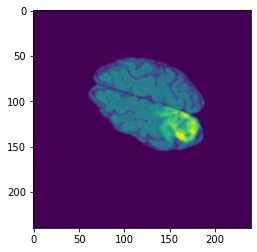

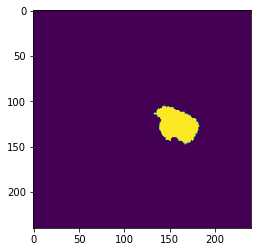

In [401]:
a, b =MRI_Dataloader(df_train, transform_train).__getitem__(90)
plt.imshow(a[0])
plt.show()
plt.imshow(b[0])

# Funções para manipulação dos dados

# Métricas

## Dice

In [6]:
def dice_metric(y_true, y_predicted, thr=0.5):
    
#     assert len(y_true.shape) == 4
#     assert len(y_predicted.shape) == 4
    assert y_true.shape == y_predicted.shape
    try:
        y_true = y_true.clone()
        y_predicted = y_predicted.clone()
        batch_size = y_true.shape[0]
        y_true = y_true.contiguous().view(-1) 
        y_predicted = y_predicted.contiguous().view(-1)

        y_predicted[y_predicted < thr] = 0
        y_predicted[y_predicted >= thr] = 1 

        mult = 2*torch.sum(y_true*y_predicted)
        sum_1 = torch.sum(y_true)
        sum_2 = torch.sum(y_predicted)
        dice = mult/(sum_1 + sum_2 + 1e-6)
        return torch.mean(dice), torch.mean(dice, dim = 0)
    except:
        batch_size = y_true.shape[0]
        y_true = y_true.reshape(-1)
        y_predicted = y_predicted.reshape(-1)

        y_predicted[y_predicted < thr] = 0
        y_predicted[y_predicted >= thr] = 1 

        mult = 2*np.sum(y_true*y_predicted)
        sum_1 = np.sum(y_true)
        sum_2 = np.sum(y_predicted)
        dice = mult/(sum_1 + sum_2 + 1e-6)
        return np.mean(dice)

In [7]:
def soft_dice(y_true, y_predicted):
    
    assert len(y_true.shape) == 4
    assert len(y_predicted.shape) == 4
    assert y_true.shape == y_predicted.shape
    y_true = y_true.clone()
    y_predicted = y_predicted.clone()
    dim_1 = y_true.shape[0]
    y_true = y_true.contiguous().view(-1)
    y_predicted = y_predicted.contiguous().view(-1)
    mult = 2*torch.sum(y_true*y_predicted)
    sum_1 = torch.sum(torch.pow(y_true, 2))
    sum_2 = torch.sum(torch.pow(y_predicted, 2))
    dice = (mult + 1)/(sum_1 + sum_2 + 1)    
    return dice

# Modelo

In [424]:
%%capture
UNet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                      in_channels = 1, 
                      out_channels = 1, 
                      init_features = 32, 
                      pretrained = False).to("cuda:0")

In [313]:
df_test.shape[0]/155

93.0

# Treinamento

## Primeiro experimento

In [9]:
mlflow.set_tracking_uri("/home/felipe-sassi/mlruns")

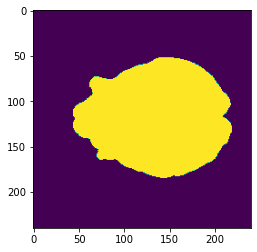

In [353]:
plt.imshow(yt_list_values[49][0])

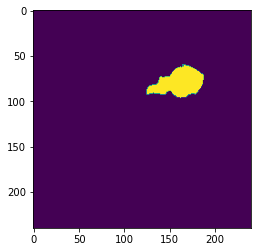

In [354]:
plt.imshow(y_list_values[49][0])

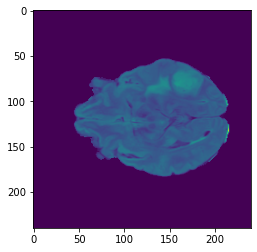

In [355]:
plt.imshow(x_list_values[49][0])

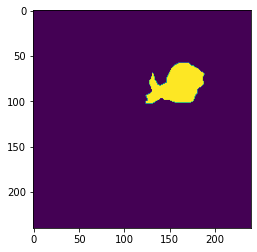

In [348]:
plt.imshow(y_list_values[60][0])

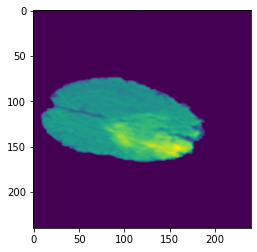

In [423]:
plt.imshow(x[6, 0].cpu().detach())

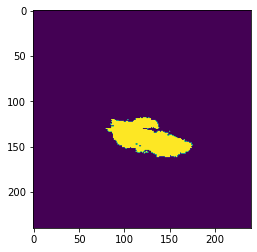

In [421]:
plt.imshow(y[6, 0].cpu().detach())

In [380]:
y.min()

tensor(0., device='cuda:0')

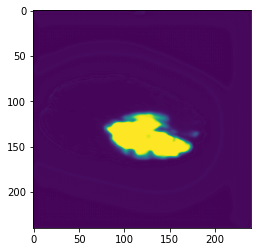

In [422]:
plt.imshow(y_predicted[6, 0].cpu().detach())

In [ ]:
df_train_temp = df_train[(df_train["SLICE"] > 15) & (df_train["SLICE"] < 139)]
Data_Train = DataLoader(MRI_Dataloader(df_train_temp, transform_train), 
                  batch_size = 12)
Epochs = 10
lr = 1e-4
Optimizer = optim.Adam(UNet.parameters(), lr = lr)
patience = 3
factor = 0.1
threshold = 0.01
LR_Scheduler = optim.lr_scheduler.ReduceLROnPlateau(Optimizer, patience = patience, threshold = threshold)
print(f"Start training for {Epochs} epochs.")
Loss = nn.BCELoss()
with mlflow.start_run(): 
    log_param("Model", "U-Net")
    log_param("Data Aug", "False")
    log_param("Init Features", 32)
    log_param("Pretrained", "False")
    log_param("Total Epochs", Epochs)
    log_param("Learning Rate", lr)
    log_param("Loss", "Dice Loss")
    log_param("Metric", "Dice")
    log_param("Optimizer", "Adam")
    log_param("Batch Size Train", 12)
    log_param('Slices', '15 - 139')
    log_param("Learning Rate Scheduler", "Reduce LR on Plateau")
    log_param("Learning Rate Scheduler Patience", patience)
    log_param("Learning Rate Scheduler Monitor", "Validation Loss")
    log_param("Learning Rate Scheduler Threshold", threshold)
    log_param("Factor", factor)
    log_model(UNet, "Models Original")
    salvar = np.zeros((10, 123, 240, 240))
    salvar1 = np.zeros((10, 123, 240, 240))
    
    internal_counter = 0
    internal_counter_1 = 0
    for e in range(Epochs):
        Total_Loss_Train = 0
#         Total_Loss = 0
        Dice_Score = 0
        Dice_Score_Channel = np.zeros(1)
        
        for x, y in tqdm_notebook(Data_Train):
            x, y = x.to("cuda:0"), y.to("cuda:0")
            Optimizer.zero_grad()
            y_predicted = UNet(x)
#             Loss_Value = 1 - soft_dice(y_predicted, y)[0]
            Loss_Value = 1 - soft_dice(y_predicted, y)
#             Loss_Value = Loss(y_predicted, y)
            Loss_Value.backward()
            Optimizer.step()
            Total_Loss_Train = Total_Loss_Train + Loss_Value.item()       
            internal_counter = internal_counter + 1
            if (internal_counter % 1414 == 0):  
                print("Validation results")
                dice = 0
                Total_Loss = 0
                for kk in tqdm_notebook(df_test["VOLUME"].unique()):
                    df_test_temp = df_test[(df_test["VOLUME"] == kk) & (df_test["SLICE"] > 15) & (df_test["SLICE"] < 139)].reset_index(drop = True)        
                    x_list_values = np.zeros((123, 1, 240, 240))
                    y_list_values = np.zeros((123, 1, 240, 240))
                    yt_list_values = np.zeros((123, 1, 240, 240))
                    for j in range(123):
                        df_test_temp_1 = df_test_temp[df_test_temp["SLICE"] == j + 16].reset_index(drop = True)
                        Data_Test_Temp = DataLoader(MRI_Dataloader(df_test_temp_1, transform_val), batch_size = 1)
                        for x, y in Data_Test_Temp:
                            x, y = x.to("cuda:0"), y.to("cuda:0")
                            y_predicted = UNet(x)
                            Loss_Value = 1 - soft_dice(y_predicted, y)
#                             Loss_Value = Loss(y_predicted, y)
                            Total_Loss = Total_Loss + Loss_Value.item()       
                        x_list_values[j] = x.cpu().numpy()
                        y_list_values[j] = y.cpu().numpy()
                        yt_list_values[j] = y_predicted.detach().cpu().numpy()
                    dice = dice + dice_metric(y_list_values, yt_list_values)
                print("Dice metric:", dice/93)
                log_metric("Loss Validation - 4X", Total_Loss/df_test.shape[0], step = internal_counter_1)
                log_metric("Dice Validation Mean - 4X", dice/93, step = internal_counter_1)                
                internal_counter_1 = internal_counter_1 + 1   
        print("Loss:", 12*Total_Loss_Train/df_train.shape[0])
        dice = 0
        for count, kk in enumerate(tqdm_notebook(df_train["VOLUME"].unique())):
            df_train_temp = df_train[(df_train["VOLUME"] == kk) & (df_train["SLICE"] > 15) & (df_train["SLICE"] < 139)].reset_index(drop = True)
            x_list_values = np.zeros((123, 1, 240, 240))
            y_list_values = np.zeros((123, 1, 240, 240))
            yt_list_values = np.zeros((123, 1, 240, 240))
            for j in range(123):
                df_train_temp_1 = df_train_temp[df_train_temp["SLICE"] == j + 16].reset_index(drop = True)
                Data_Train_Temp = DataLoader(MRI_Dataloader(df_train_temp_1, transform_train), batch_size = 1)
                for x, y in Data_Train_Temp:
                    x, y = x.to("cuda:0"), y.to("cuda:0")
                    y_predicted = UNet(x)
                x_list_values[j] = x.cpu().numpy()
                y_list_values[j] = y.cpu().numpy()
                yt_list_values[j] = y_predicted.detach().cpu().numpy()
                if count < 10:
                    salvar[count, j] = y_predicted.detach().cpu().numpy()
                    salvar1[count, j] = y.cpu().numpy()
            dice = dice + dice_metric(y_list_values, yt_list_values)
        print("Dice metric:", dice/276)
        Total_Loss = 12*Total_Loss_Train/df_train.shape[0]
        log_metric("Loss Train", Total_Loss, step = e)
        log_metric("Dice Train Mean", dice/276, step = e)                
        print("Validation results")
        dice = 0
        Total_Loss = 0
        for kk in tqdm_notebook(df_test["VOLUME"].unique()):
            df_test_temp = df_test[(df_test["VOLUME"] == kk) & (df_test["SLICE"] > 15) & (df_test["SLICE"] < 139)].reset_index(drop = True)
            x_list_values = np.zeros((123, 1, 240, 240))
            y_list_values = np.zeros((123, 1, 240, 240))
            yt_list_values = np.zeros((123, 1, 240, 240))
            for j in range(123):
                df_test_temp_1 = df_test_temp[df_test_temp["SLICE"] == j + 16].reset_index(drop = True)
                Data_Test_Temp = DataLoader(MRI_Dataloader(df_test_temp_1, transform_val), batch_size = 1)
                for x, y in Data_Test_Temp:
                    x, y = x.to("cuda:0"), y.to("cuda:0")
                    y_predicted = UNet(x)
                    Loss_Value = 1 - soft_dice(y_predicted, y)
#                     Loss_Value = Loss(y_predi cted, y)
                    Total_Loss = Total_Loss + Loss_Value.item()       
                x_list_values[j] = x.cpu().numpy()
                y_list_values[j] = y.cpu().numpy()
                yt_list_values[j] = y_predicted.detach().cpu().numpy()
            dice = dice + dice_metric(y_list_values, yt_list_values)
        print("Dice metric:", dice/93)
        log_metric("Loss Validation", Total_Loss/df_test.shape[0], step = e)
        log_metric("Dice Validation Mean", dice/93, step = e)                
        LR_Scheduler.step(Total_Loss)    
        for i in Optimizer.param_groups:
            lr_s = i["lr"]
        log_metric("Learning Rate", lr_s, step = e)  
    log_model(UNet, "Models Trained")

Start training for 10 epochs.


Validation results



Dice metric: 0.646824131660889
Validation results



Dice metric: 0.6885809978925448

Loss: 0.27241893441613557



Dice metric: 0.6577077048459269
Validation results



Dice metric: 0.693014397065841


In [521]:
 %%capture
UNet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                      in_channels = 1, 
                      out_channels = 1, 
                      init_features = 32, 
                      pretrained = False).to("cuda:0")

In [520]:
transform_train = A.Compose([
        A.Rotate((-20, 20)),
        A.RandomBrightness(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Normalize(0, 1),
], p=1)


In [522]:
df_train_temp = df_train[(df_train["SLICE"] > 15) & (df_train["SLICE"] < 139)]
Data_Train = DataLoader(MRI_Dataloader(df_train_temp, transform_train), 
                  batch_size = 12)
Epochs = 10
lr = 1e-4
Optimizer = optim.Adam(UNet.parameters(), lr = lr)
patience = 3
factor = 0.1
threshold = 0.01
LR_Scheduler = optim.lr_scheduler.ReduceLROnPlateau(Optimizer, patience = patience, threshold = threshold)
print(f"Start training for {Epochs} epochs.")
Loss = nn.BCELoss()
with mlflow.start_run(): 
    log_param("Model", "U-Net")
    log_param("Data Aug", "False")
    log_param("Init Features", 32)
    log_param("Pretrained", "False")
    log_param("Total Epochs", Epochs)
    log_param("Learning Rate", lr)
    log_param("Loss", "Dice Loss")
    log_param("Metric", "Dice")
    log_param("Optimizer", "Adam")
    log_param("Batch Size Train", 12)
    log_param('Slices', '15 - 139')
    log_param("Learning Rate Scheduler", "Reduce LR on Plateau")
    log_param("Learning Rate Scheduler Patience", patience)
    log_param("Learning Rate Scheduler Monitor", "Validation Loss")
    log_param("Learning Rate Scheduler Threshold", threshold)
    log_param("Factor", factor)
    log_model(UNet, "Models Original")
    salvar = np.zeros((10, 123, 240, 240))
    salvar1 = np.zeros((10, 123, 240, 240))
    
    internal_counter = 0
    internal_counter_1 = 0
    for e in range(Epochs):
        Total_Loss_Train = 0
#         Total_Loss = 0
        Dice_Score = 0
        Dice_Score_Channel = np.zeros(1)
        
        for x, y in tqdm_notebook(Data_Train):
            x, y = x.to("cuda:0"), y.to("cuda:0")
            Optimizer.zero_grad()
            y_predicted = UNet(x)
#             Loss_Value = 1 - soft_dice(y_predicted, y)[0]
            Loss_Value = 1 - soft_dice(y_predicted, y)
#             Loss_Value = Loss(y_predicted, y)
            Loss_Value.backward()
            Optimizer.step()
            Total_Loss_Train = Total_Loss_Train + Loss_Value.item()       
            internal_counter = internal_counter + 1
            if (internal_counter % 1414 == 0):  
                print("Validation results")
                dice = 0
                Total_Loss = 0
                for kk in tqdm_notebook(df_test["VOLUME"].unique()):
                    df_test_temp = df_test[(df_test["VOLUME"] == kk) & (df_test["SLICE"] > 15) & (df_test["SLICE"] < 139)].reset_index(drop = True)        
                    x_list_values = np.zeros((123, 1, 240, 240))
                    y_list_values = np.zeros((123, 1, 240, 240))
                    yt_list_values = np.zeros((123, 1, 240, 240))
                    for j in range(123):
                        df_test_temp_1 = df_test_temp[df_test_temp["SLICE"] == j + 16].reset_index(drop = True)
                        Data_Test_Temp = DataLoader(MRI_Dataloader(df_test_temp_1, transform_val), batch_size = 1)
                        for x, y in Data_Test_Temp:
                            x, y = x.to("cuda:0"), y.to("cuda:0")
                            y_predicted = UNet(x)
                            Loss_Value = 1 - soft_dice(y_predicted, y)
#                             Loss_Value = Loss(y_predicted, y)
                            Total_Loss = Total_Loss + Loss_Value.item()       
                        x_list_values[j] = x.cpu().numpy()
                        y_list_values[j] = y.cpu().numpy()
                        yt_list_values[j] = y_predicted.detach().cpu().numpy()
                    dice = dice + dice_metric(y_list_values, yt_list_values)
                print("Dice metric:", dice/93)
                log_metric("Loss Validation - 4X", Total_Loss/df_test.shape[0], step = internal_counter_1)
                log_metric("Dice Validation Mean - 4X", dice/93, step = internal_counter_1)                
                internal_counter_1 = internal_counter_1 + 1   
        print("Loss:", 12*Total_Loss_Train/df_train.shape[0])
        dice = 0
        for count, kk in enumerate(tqdm_notebook(df_train["VOLUME"].unique())):
            df_train_temp = df_train[(df_train["VOLUME"] == kk) & (df_train["SLICE"] > 15) & (df_train["SLICE"] < 139)].reset_index(drop = True)
            x_list_values = np.zeros((123, 1, 240, 240))
            y_list_values = np.zeros((123, 1, 240, 240))
            yt_list_values = np.zeros((123, 1, 240, 240))
            for j in range(123):
                df_train_temp_1 = df_train_temp[df_train_temp["SLICE"] == j + 16].reset_index(drop = True)
                Data_Train_Temp = DataLoader(MRI_Dataloader(df_train_temp_1, transform_train), batch_size = 1)
                for x, y in Data_Train_Temp:
                    x, y = x.to("cuda:0"), y.to("cuda:0")
                    y_predicted = UNet(x)
                x_list_values[j] = x.cpu().numpy()
                y_list_values[j] = y.cpu().numpy()
                yt_list_values[j] = y_predicted.detach().cpu().numpy()
                if count < 10:
                    salvar[count, j] = y_predicted.detach().cpu().numpy()
                    salvar1[count, j] = y.cpu().numpy()
            dice = dice + dice_metric(y_list_values, yt_list_values)
        print("Dice metric:", dice/276)
        Total_Loss = 12*Total_Loss_Train/df_train.shape[0]
        log_metric("Loss Train", Total_Loss, step = e)
        log_metric("Dice Train Mean", dice/276, step = e)                
        print("Validation results")
        dice = 0
        Total_Loss = 0
        for kk in tqdm_notebook(df_test["VOLUME"].unique()):
            df_test_temp = df_test[(df_test["VOLUME"] == kk) & (df_test["SLICE"] > 15) & (df_test["SLICE"] < 139)].reset_index(drop = True)
            x_list_values = np.zeros((123, 1, 240, 240))
            y_list_values = np.zeros((123, 1, 240, 240))
            yt_list_values = np.zeros((123, 1, 240, 240))
            for j in range(123):
                df_test_temp_1 = df_test_temp[df_test_temp["SLICE"] == j + 16].reset_index(drop = True)
                Data_Test_Temp = DataLoader(MRI_Dataloader(df_test_temp_1, transform_val), batch_size = 1)
                for x, y in Data_Test_Temp:
                    x, y = x.to("cuda:0"), y.to("cuda:0")
                    y_predicted = UNet(x)
                    Loss_Value = 1 - soft_dice(y_predicted, y)
#                     Loss_Value = Loss(y_predicted, y)
                    Total_Loss = Total_Loss + Loss_Value.item()       
                x_list_values[j] = x.cpu().numpy()
                y_list_values[j] = y.cpu().numpy()
                yt_list_values[j] = y_predicted.detach().cpu().numpy()
            dice = dice + dice_metric(y_list_values, yt_list_values)
        print("Dice metric:", dice/93)
        log_metric("Loss Validation", Total_Loss/df_test.shape[0], step = e)
        log_metric("Dice Validation Mean", dice/93, step = e)                
        LR_Scheduler.step(Total_Loss)    
        for i in Optimizer.param_groups:
            lr_s = i["lr"]
        log_metric("Learning Rate", lr_s, step = e)  
    log_model(UNet, "Models Trained")

Start training for 10 epochs.


Validation results



Dice metric: 0.46786829666553076
Validation results



Dice metric: 0.5763943825125211

Loss: 0.44482742542973075



Dice metric: 0.456082653225795
Validation results



Dice metric: 0.582450978303823


Validation results



Dice metric: 0.5964158803874984
Validation results



Dice metric: 0.6032399641734997

Loss: 0.22489787940390482



Dice metric: 0.5028031809450103
Validation results



Dice metric: 0.6173750864328547


Validation results



Dice metric: 0.7688105196611544
Validation results



Dice metric: 0.7469972430830883

Loss: 0.20798956022021814



Dice metric: 0.5900606931481671
Validation results



Dice metric: 0.7607088657377663


Validation results



Dice metric: 0.7777455837271068
Validation results



Dice metric: 0.7709740719002212

Loss: 0.1981213825113476



Dice metric: 0.6344240991850807
Validation results



Dice metric: 0.7860235917064302


Validation results



Dice metric: 0.7958641841176257
Validation results



Dice metric: 0.7845329648689036

Loss: 0.1923256814730619



Dice metric: 0.6326620642190476
Validation results



Dice metric: 0.7858380579227384


Validation results



Dice metric: 0.7894764737677137
Validation results



Dice metric: 0.7380390801841978

Loss: 0.18577033267950777



Dice metric: 0.6149982408548104
Validation results



Dice metric: 0.7516353886363797


Validation results



Dice metric: 0.818274645826317
Validation results



Dice metric: 0.7749837213474128

Loss: 0.18407736468281685



Dice metric: 0.6365920554741243
Validation results



Dice metric: 0.7744116103750953


Validation results



Dice metric: 0.8181287324193786
Validation results



Dice metric: 0.7865332327213408

Loss: 0.17934943221896094



Dice metric: 0.6538078862752534
Validation results



Dice metric: 0.7831650383245404


Validation results



Dice metric: 0.8076483264521571
Validation results



Dice metric: 0.7916779151511195

Loss: 0.17356598634706474



Dice metric: 0.6606948464005874
Validation results



Dice metric: 0.7958849176548626


Validation results



Dice metric: 0.833494454928747
Validation results



Dice metric: 0.8212625701722256

Loss: 0.17181866041908425



Dice metric: 0.6684399790124225
Validation results



Dice metric: 0.8236223101204263


In [523]:
transform_train = A.Compose([
        A.Rotate((-20, 20)),
        A.RandomBrightness(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ElasticTransform(720, 50),
        A.Normalize(0, 1),
], p=1)


In [524]:
 %%capture
UNet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                      in_channels = 1, 
                      out_channels = 1, 
                      init_features = 32, 
                      pretrained = False).to("cuda:0")

In [ ]:
df_train_temp = df_train[(df_train["SLICE"] > 15) & (df_train["SLICE"] < 139)]
Data_Train = DataLoader(MRI_Dataloader(df_train_temp, transform_train), 
                  batch_size = 12)
Epochs = 10
lr = 1e-4
Optimizer = optim.Adam(UNet.parameters(), lr = lr)
patience = 3
factor = 0.1
threshold = 0.01
LR_Scheduler = optim.lr_scheduler.ReduceLROnPlateau(Optimizer, patience = patience, threshold = threshold)
print(f"Start training for {Epochs} epochs.")
Loss = nn.BCELoss()
with mlflow.start_run(): 
    log_param("Model", "U-Net")
    log_param("Data Aug", "False")
    log_param("Init Features", 32)
    log_param("Pretrained", "False")
    log_param("Total Epochs", Epochs)
    log_param("Learning Rate", lr)
    log_param("Loss", "Dice Loss")
    log_param("Metric", "Dice")
    log_param("Optimizer", "Adam")
    log_param("Batch Size Train", 12)
    log_param('Slices', '15 - 139')
    log_param("Learning Rate Scheduler", "Reduce LR on Plateau")
    log_param("Learning Rate Scheduler Patience", patience)
    log_param("Learning Rate Scheduler Monitor", "Validation Loss")
    log_param("Learning Rate Scheduler Threshold", threshold)
    log_param("Factor", factor)
    log_model(UNet, "Models Original")
    salvar = np.zeros((10, 123, 240, 240))
    salvar1 = np.zeros((10, 123, 240, 240))
    
    internal_counter = 0
    internal_counter_1 = 0
    for e in range(Epochs):
        Total_Loss_Train = 0
#         Total_Loss = 0
        Dice_Score = 0
        Dice_Score_Channel = np.zeros(1)
        
        for x, y in tqdm_notebook(Data_Train):
            x, y = x.to("cuda:0"), y.to("cuda:0")
            Optimizer.zero_grad()
            y_predicted = UNet(x)
#             Loss_Value = 1 - soft_dice(y_predicted, y)[0]
            Loss_Value = 1 - soft_dice(y_predicted, y)
#             Loss_Value = Loss(y_predicted, y)
            Loss_Value.backward()
            Optimizer.step()
            Total_Loss_Train = Total_Loss_Train + Loss_Value.item()       
            internal_counter = internal_counter + 1
            if (internal_counter % 1414 == 0):  
                print("Validation results")
                dice = 0
                Total_Loss = 0
                for kk in tqdm_notebook(df_test["VOLUME"].unique()):
                    df_test_temp = df_test[(df_test["VOLUME"] == kk) & (df_test["SLICE"] > 15) & (df_test["SLICE"] < 139)].reset_index(drop = True)        
                    x_list_values = np.zeros((123, 1, 240, 240))
                    y_list_values = np.zeros((123, 1, 240, 240))
                    yt_list_values = np.zeros((123, 1, 240, 240))
                    for j in range(123):
                        df_test_temp_1 = df_test_temp[df_test_temp["SLICE"] == j + 16].reset_index(drop = True)
                        Data_Test_Temp = DataLoader(MRI_Dataloader(df_test_temp_1, transform_val), batch_size = 1)
                        for x, y in Data_Test_Temp:
                            x, y = x.to("cuda:0"), y.to("cuda:0")
                            y_predicted = UNet(x)
                            Loss_Value = 1 - soft_dice(y_predicted, y)
#                             Loss_Value = Loss(y_predicted, y)
                            Total_Loss = Total_Loss + Loss_Value.item()       
                        x_list_values[j] = x.cpu().numpy()
                        y_list_values[j] = y.cpu().numpy()
                        yt_list_values[j] = y_predicted.detach().cpu().numpy()
                    dice = dice + dice_metric(y_list_values, yt_list_values)
                print("Dice metric:", dice/93)
                log_metric("Loss Validation - 4X", Total_Loss/df_test.shape[0], step = internal_counter_1)
                log_metric("Dice Validation Mean - 4X", dice/93, step = internal_counter_1)                
                internal_counter_1 = internal_counter_1 + 1   
        print("Loss:", 12*Total_Loss_Train/df_train.shape[0])
        dice = 0
        for count, kk in enumerate(tqdm_notebook(df_train["VOLUME"].unique())):
            df_train_temp = df_train[(df_train["VOLUME"] == kk) & (df_train["SLICE"] > 15) & (df_train["SLICE"] < 139)].reset_index(drop = True)
            x_list_values = np.zeros((123, 1, 240, 240))
            y_list_values = np.zeros((123, 1, 240, 240))
            yt_list_values = np.zeros((123, 1, 240, 240))
            for j in range(123):
                df_train_temp_1 = df_train_temp[df_train_temp["SLICE"] == j + 16].reset_index(drop = True)
                Data_Train_Temp = DataLoader(MRI_Dataloader(df_train_temp_1, transform_train), batch_size = 1)
                for x, y in Data_Train_Temp:
                    x, y = x.to("cuda:0"), y.to("cuda:0")
                    y_predicted = UNet(x)
                x_list_values[j] = x.cpu().numpy()
                y_list_values[j] = y.cpu().numpy()
                yt_list_values[j] = y_predicted.detach().cpu().numpy()
                if count < 10:
                    salvar[count, j] = y_predicted.detach().cpu().numpy()
                    salvar1[count, j] = y.cpu().numpy()
            dice = dice + dice_metric(y_list_values, yt_list_values)
        print("Dice metric:", dice/276)
        Total_Loss = 12*Total_Loss_Train/df_train.shape[0]
        log_metric("Loss Train", Total_Loss, step = e)
        log_metric("Dice Train Mean", dice/276, step = e)                
        print("Validation results")
        dice = 0
        Total_Loss = 0
        for kk in tqdm_notebook(df_test["VOLUME"].unique()):
            df_test_temp = df_test[(df_test["VOLUME"] == kk) & (df_test["SLICE"] > 15) & (df_test["SLICE"] < 139)].reset_index(drop = True)
            x_list_values = np.zeros((123, 1, 240, 240))
            y_list_values = np.zeros((123, 1, 240, 240))
            yt_list_values = np.zeros((123, 1, 240, 240))
            for j in range(123):
                df_test_temp_1 = df_test_temp[df_test_temp["SLICE"] == j + 16].reset_index(drop = True)
                Data_Test_Temp = DataLoader(MRI_Dataloader(df_test_temp_1, transform_val), batch_size = 1)
                for x, y in Data_Test_Temp:
                    x, y = x.to("cuda:0"), y.to("cuda:0")
                    y_predicted = UNet(x)
                    Loss_Value = 1 - soft_dice(y_predicted, y)
#                     Loss_Value = Loss(y_predicted, y)
                    Total_Loss = Total_Loss + Loss_Value.item()       
                x_list_values[j] = x.cpu().numpy()
                y_list_values[j] = y.cpu().numpy()
                yt_list_values[j] = y_predicted.detach().cpu().numpy()
            dice = dice + dice_metric(y_list_values, yt_list_values)
        print("Dice metric:", dice/93)
        log_metric("Loss Validation", Total_Loss/df_test.shape[0], step = e)
        log_metric("Dice Validation Mean", dice/93, step = e)                
        LR_Scheduler.step(Total_Loss)    
        for i in Optimizer.param_groups:
            lr_s = i["lr"]
        log_metric("Learning Rate", lr_s, step = e)  
    log_model(UNet, "Models Trained")

Start training for 10 epochs.
